In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import json
import pandas as pd
from typing import *
from os import listdir
from os.path import isfile, join
from enum import Enum

# Plots

In [2]:
class PlotType(Enum):
    REWARDS = 1
    WEIGHTS = 2

def plot(match_id: str, plot_type: PlotType, title: str = ""):    
    filepath = ""
    y_label = ""
    if plot_type == PlotType.REWARDS:
        filepath = "dump/rewards"
        y_label = "Reward"
        if title == "": 
            title = "Rewards from " + match_id
    elif plot_type == PlotType.WEIGHTS:
        filepath = "dump/weights"
        y_label = "Weights Value"
        if title == "": 
            title = "Weights from " + match_id

        
    with open(f"{filepath}/{match_id}.pt", "rb") as file:
        data = pickle.load(file)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(0, len(data)), data)
    plt.xlabel('Episode')
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

def plot_all_rewards():
    path = "dump/rewards"
    files = [f for f in listdir(path) if isfile(join(path, f))]
    for file in files:
        plot(file[:-3], PlotType.REWARDS)

def plot_all_weights():
    path = "dump/weights"
    files = [f for f in listdir(path) if isfile(join(path, f))]
    for file in files:
        plot(file[:-3], PlotType.WEIGHTS)

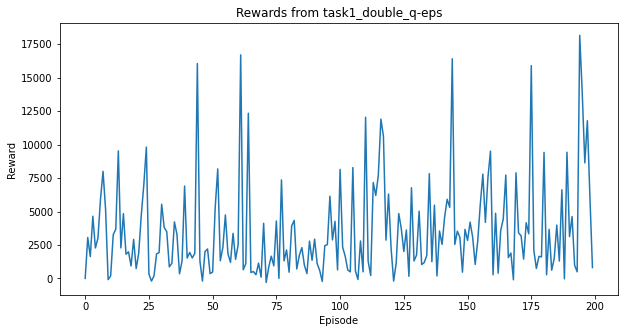

In [48]:
plot("task1_double_q-eps", PlotType.REWARDS)

In [3]:
# plot_all_rewards()
# plot_all_weights()

# Training Ranking

In [19]:
def get_rewards_for_runner(runner_id: str, n_rounds: int, n_rewards_iterations: int) -> dict:
    filename = f"runner-{runner_id}_rounds-{n_rounds}_rewards-{n_rewards_iterations}.json"
    
    with open(f"results/{filename}", "rb") as file:
        runner_rewards = json.load(file)
    
    
    return runner_rewards


def get_stats_for_matches(match_ids: List[str]):
    match_stats = {}
    match_stats_train = {}
    for match_id in match_ids:
        if match_id == "general":
            continue
        with open(f"results/{match_id}.json", "rb") as file:
            match_stats[match_id] = json.load(file)
        with open(f"results/{match_id}_train.json", "rb") as file:
            match_stats_train[match_id] = json.load(file)
        
    return match_stats, match_stats_train

def get_relevant_data_for_matches(runner_match_stats: dict, agent: str) -> dict:
    relevant_data = {}
    for match_id, match_stats in runner_match_stats.items():
        relevant_data[match_id] = {
            "general": match_stats["by_agent"][agent],
            "rounds": [r for r in match_stats["by_round"].values()],
        }
        
    return relevant_data

def get_aggregated_round_stats(relevant_match_stats: dict) -> dict:
    aggregated_stats = {}
    for match_id, match_stats in relevant_match_stats.items():
        n_rounds = match_stats["general"]["rounds"]
        n_coins, n_kills, n_score = 0, 0, 0
        for match_round in match_stats["rounds"]:
            n_coins += match_round['coins_train']
            n_kills += match_round['kills_train']
            n_score += match_round['coins_train'] + 5 * match_round['kills_train']
        aggregated_stats[match_id] = {
            "avg_coins":  n_coins / n_rounds  if n_coins > 0 else 0,
            "avg_kills":  n_kills / n_rounds  if n_kills > 0 else 0,
            "avg_score": n_score / n_rounds if n_score > 0 else 0,
        }
    
    return aggregated_stats

def get_runner_stats(runner_rewards: dict, relevant_match_stats: dict):
    agg_stats =  get_aggregated_round_stats(relevant_match_stats)
    
    df = pd.DataFrame(columns = ['Name', 'Rounds', 'Total Coins', 'Avg Coins', 'Kills', 'Avg Kills', 'Score', 
                                 'Avg Score', 'Suicides', 'Invalid', 'Moves', 'Crates', 'Eps', 'Alpha', 'Gamma'])

    idx = 0
    for match_id, match_stats in relevant_match_stats.items():
        general = match_stats["general"]
        match = {'Name' : match_id, 'Rounds': general[ "rounds"] , 
                 'Total Coins': general["coins"] if 'coins' in general else 0,
                 'Avg Coins': agg_stats[match_id]["avg_coins"], 
                 'Kills': general["kills"] if 'kills' in general else 0,
                 'Avg Kills': agg_stats[match_id]["avg_kills"], 'Score': general["score"],  
                 'Avg Score': agg_stats[match_id]["avg_score"], 
                 'Suicides': general["suicides"] if 'suicides' in general else 0,
                 'Invalid': general["invalid"] if 'invalid' in general else 0, 
                 'Moves': general["moves"] if 'moves' in general else 0, 
                 'Crates': general["crates"] if 'crates' in general else 0,
                'Eps': runner_rewards["general"]["eps"], 'Alpha':runner_rewards["general"]["alpha"], 
                 'Gamma': runner_rewards["general"]["gamma"]
        }
        df.loc[idx] = match
        idx += 1
    
    return df

In [44]:
runner_id = "1W82"
n_rounds = 30
n_rewards_iterations = 5
agent= "fml"

runner_rewards = get_rewards_for_runner(runner_id, n_rounds, n_rewards_iterations)
runner_match_stats, runner_match_stats_train = get_stats_for_matches(list(runner_rewards.keys()))
runner_match_stats, runner_match_stats_train = get_stats_for_matches(match_ids)

relevant_match_stats = get_relevant_data_for_matches(runner_match_stats, agent)
stats = get_runner_stats(runner_rewards, relevant_match_stats)
stats_sorted = stats.sort_values(by='Avg Score', ascending=False)
display(stats_sorted)

,Name,Rounds,Total Coins,Avg Coins,Kills,Avg Kills,Score,Avg Score,Suicides,Invalid,Moves,Crates,Eps,Alpha,Gamma
2,UG56-task1_double_q-W772,50,58,1.16,4,0.08,78,1.56,48,63,2364,461,0.15,0.05,0.85
5,UG56-task1_double_q-V4O5,50,26,0.52,5,0.10,51,1.02,35,11,7011,655,0.15,0.05,0.85
7,UG56-task1_double_q-2ZGL,50,42,0.84,1,0.02,47,0.94,7,11,15204,600,0.15,0.05,0.85
0,UG56-task1_double_q-836C,50,24,0.48,4,0.08,44,0.88,2,17,16678,590,0.15,0.05,0.85
1,UG56-task1_double_q-7L0V,50,29,0.58,0,0.00,29,0.58,45,46,1077,473,0.15,0.05,0.85
4,UG56-task1_double_q-G24I,50,12,0.24,1,0.02,17,0.34,47,3,2286,472,0.15,0.05,0.85
6,UG56-task1_double_q-1HVZ,50,6,0.12,1,0.02,11,0.22,35,78,7547,117,0.15,0.05,0.85
3,UG56-task1_double_q-K65F,50,0,0.00,0,0.00,0,0.00,50,141,112,137,0.15,0.05,0.85
